# Statistics on Results

## Locked

### Converting into frequency and PSD - doing FF and using convertion factor

In [1]:
import os
import numpy as np
import pandas as pd

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Sicherstellen, dass f nie 0 ist
    return A * f_safe**(-B)

def process_parquet_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for file in os.listdir(input_folder):
        if file.endswith(".parquet"):
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)
            
            try:
                data = pd.read_parquet(input_path)
            except Exception as e:
                print(f"Fehler beim Einlesen von {file}: {e}")
                continue
            
            time = data.iloc[:, 0].values  # Zeit
            sig = data.iloc[:, 1].values  # Signal
            
            # Parameter für Spektrale Leistungsdichte
            zff = 1
            coeff_VHz = 0.576e-6
            print(f'Conversion V/Hz : {coeff_VHz * 1e6:.4f} V/MHz')
            
            # FFT-Länge berechnen
            fft_length = int(2**(np.floor(np.log2(len(sig))) + zff))
            
            spc = np.abs(np.fft.rfft(np.blackman(len(time)) * (sig / -coeff_VHz), fft_length)) / len(time)
            freq = np.fft.rfftfreq(fft_length, np.mean(np.diff(time)))
            
            psds = 2 * spc**2 / (
                np.sum(np.blackman(len(time))**2) 
                / (len(sig)**2 * np.mean(np.diff(time)))
            )
            
            # Daten in DataFrame speichern und als Parquet exportieren
            result_df = pd.DataFrame({'Frequenz (Hz)': freq, 'PSD': psds})
            result_df.to_parquet(output_path, index=False)
            print(f"Ergebnis gespeichert: {output_path}")

input_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_locked'
output_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_locked\\Parquet_locked_FF_PSD'

process_parquet_files(input_folder, output_folder)


Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f_0V_01.parquet
Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f_0V_02.parquet
Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f_0V_03.parquet
Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f_0V_04.parquet
Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f

### Statistics

In [2]:
import os
import pandas as pd
import numpy as np

def merge_parquet_files(input_folder, output_folder, freq_column="Frequency", output_filename="merged.parquet"):
    all_data = []
    
    # Read all Parquet files in the input folder
    for file in sorted(os.listdir(input_folder)):  # Ensure order consistency
        if file.endswith(".parquet"):
            file_path = os.path.join(input_folder, file)
            df = pd.read_parquet(file_path)
            all_data.append(df)
    
    if not all_data:
        print("No Parquet files found in the specified folder.")
        return
    
    # Stack all data into a 3D NumPy array (rows x columns x files)
    stacked_data = np.stack([df.values for df in all_data], axis=2)

    # Compute mean across files (axis=2)
    mean_values = np.mean(stacked_data, axis=2)
    
    # Compute std deviation across files only for the Frequency column
    if freq_column in all_data[0].columns:
        freq_idx = all_data[0].columns.get_loc(freq_column)  # Get index of frequency column
        freq_std = np.std(stacked_data[:, freq_idx, :], axis=1)  # Standard deviation for each row
        
        # Calculate the mean of the frequency standard deviation column
        mean_freq_std = np.mean(freq_std)
        print(f"Mean of the Frequency Standard Deviation column: {mean_freq_std}")
    else:
        print(f"Column '{freq_column}' not found. Skipping standard deviation calculation.")
        freq_std = np.zeros(mean_values.shape[0])  # Placeholder if column is missing
    
    # Create DataFrame for output
    output_df = pd.DataFrame(mean_values, columns=all_data[0].columns)
    output_df[f"{freq_column}_std"] = freq_std  # Add frequency standard deviation column
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Save to new Parquet file
    output_path = os.path.join(output_folder, output_filename)
    output_df.to_parquet(output_path)
    
    print(f"Merged file saved at: {output_path}")


path_to_input_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_locked\\Parquet_locked_FF_PSD'
path_to_output_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_locked\\Parquet_locked_FF_PSD\\MERGED_mean'

merge_parquet_files(path_to_input_folder, path_to_output_folder, freq_column="Frequenz (Hz)")


Mean of the Frequency Standard Deviation column: 3.394396076774668e-10
Merged file saved at: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\MERGED_mean\merged.parquet


### Plot all Data - locked

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f_0V_01.parquet...
Schnittpunkt der 1/f-Kurve mit der Beta-Linie: 78.701 kHz


C:\Users\samse\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


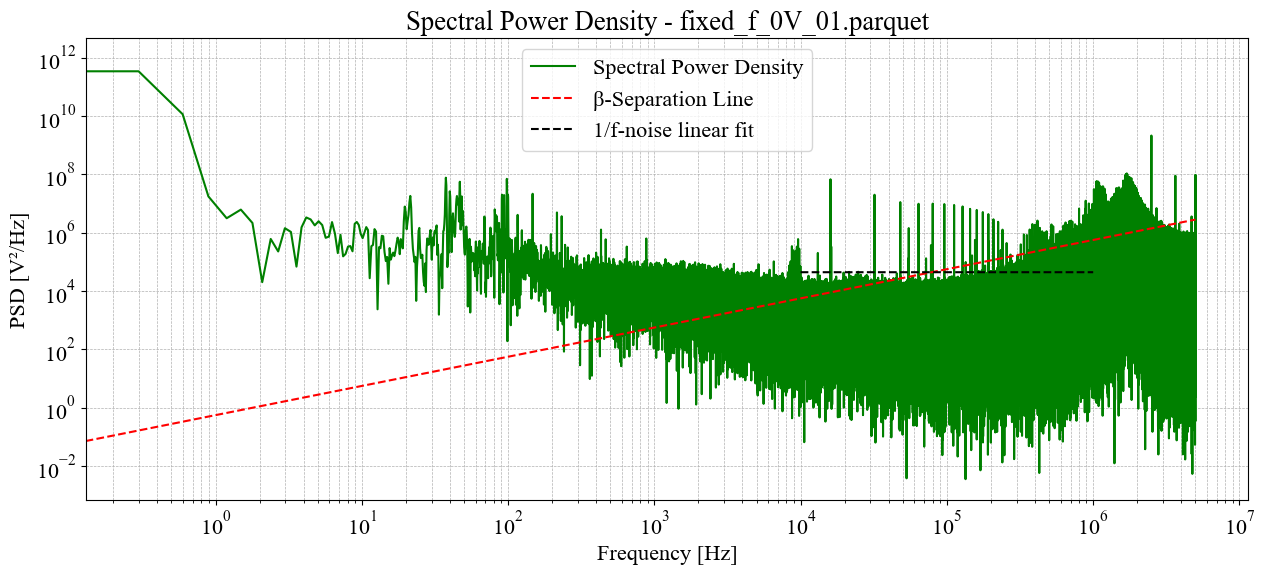

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f_0V_02.parquet...
Schnittpunkt der 1/f-Kurve mit der Beta-Linie: 94.416 kHz


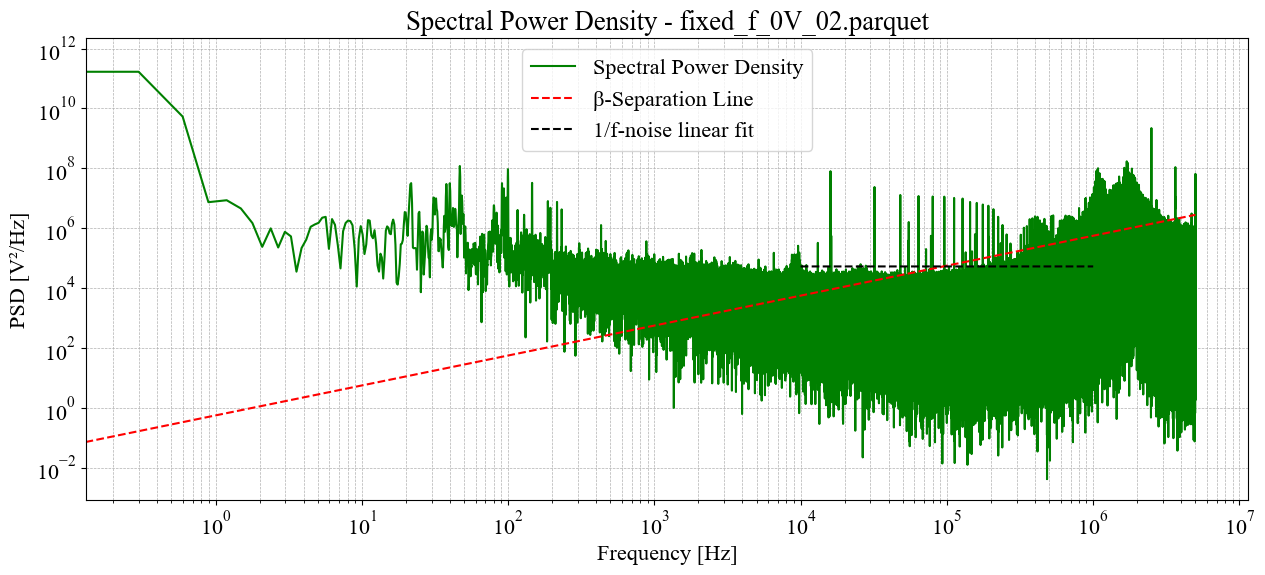

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\fixed_f_0V_03.parquet...


: 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set font properties for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Ensure f never reaches 0
    return A * f_safe**(-B)

def process_parquet_file(parquet_filename, freq_column="X", psd_column="Y"):
    try:
        # Read Parquet file
        data = pd.read_parquet(parquet_filename)
    except Exception as e:
        print(f"Error reading {parquet_filename}: {e}")
        return

    # Extract frequency and PSD columns
    if freq_column not in data.columns or psd_column not in data.columns:
        print(f"Columns '{freq_column}' and/or '{psd_column}' not found in {parquet_filename}.")
        return
    
    freq = data[freq_column].values  # Frequency axis (X)
    psds = data[psd_column].values   # Power spectral density (Y)

    print(f'Processing {parquet_filename}...')

    # Compute the β-separation line
    beta_sep_full = (8 * np.log(2) / (np.pi**2)) * freq

    # Define fitting range for 1/f noise (select relevant frequency region)
    idx = np.where((freq > 3e2) & (psds < 4e7) & (freq < 2e4))

    freq_idx = freq[idx[0]]
    psds_idx = psds[idx[0]]

    if len(freq_idx) == 0 or len(psds_idx) == 0:
        print("No valid data points for curve fitting.")
        return

    # Curve fitting with power law (1/f noise)
    try:
        popt_ps, _ = curve_fit(
            power_law, freq_idx, psds_idx, 
            p0=[1e6, 1],  # Initial values
            bounds=([1e-6, 0], [1e12, 5])  # Bounds for A and B
        )
    except RuntimeError:
        print("Curve fitting failed.")
        return

    # Compute fitted curve
    fit_curve = power_law(freq_idx, *popt_ps)

    # Compute intersection with β-separation line
    beta_sep = (8 * np.log(2) / (np.pi**2)) * freq_idx
    id_crossing = np.argwhere(np.diff(np.sign(fit_curve - beta_sep))).flatten()

    if len(id_crossing) > 0:
        cfreq = freq_idx[id_crossing][0]
        print(f'Schnittpunkt der 1/f-Kurve mit der Beta-Linie: {cfreq * 1e-3:.3f} kHz')
    else:
        print("No intersection found.")

    # Plot spectral power density
    plt.figure(figsize=(15, 6))
    plt.loglog(freq, psds, label='Spectral Power Density', color='green')
    plt.loglog(freq, beta_sep_full, 'r--', label='β-Separation Line')
    plt.loglog(freq_idx, fit_curve, label=f'1/f-noise linear fit', color='black', linestyle='--')

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V²/Hz]')
    plt.title(f'Spectral Power Density - {os.path.basename(parquet_filename)}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def process_parquet_files(folder_path, freq_column="X", psd_column="Y"):
    """Iterates over all Parquet files in the folder and processes them."""
    for file in sorted(os.listdir(folder_path)):  # Sort for consistency
        if file.endswith(".parquet"):
            file_path = os.path.join(folder_path, file)
            process_parquet_file(file_path, freq_column, psd_column)


input_folder_data = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_locked\\Parquet_locked_FF_PSD'

# Example usage: Change the path to your folder containing Parquet files
process_parquet_files(input_folder_data, freq_column="Frequenz (Hz)", psd_column="PSD")


### Plot the Mean - locked

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_locked\Parquet_locked_FF_PSD\MERGED_mean...
Schnittpunkt der 1/f-Kurve mit der Beta-Linie: 12.126 kHz


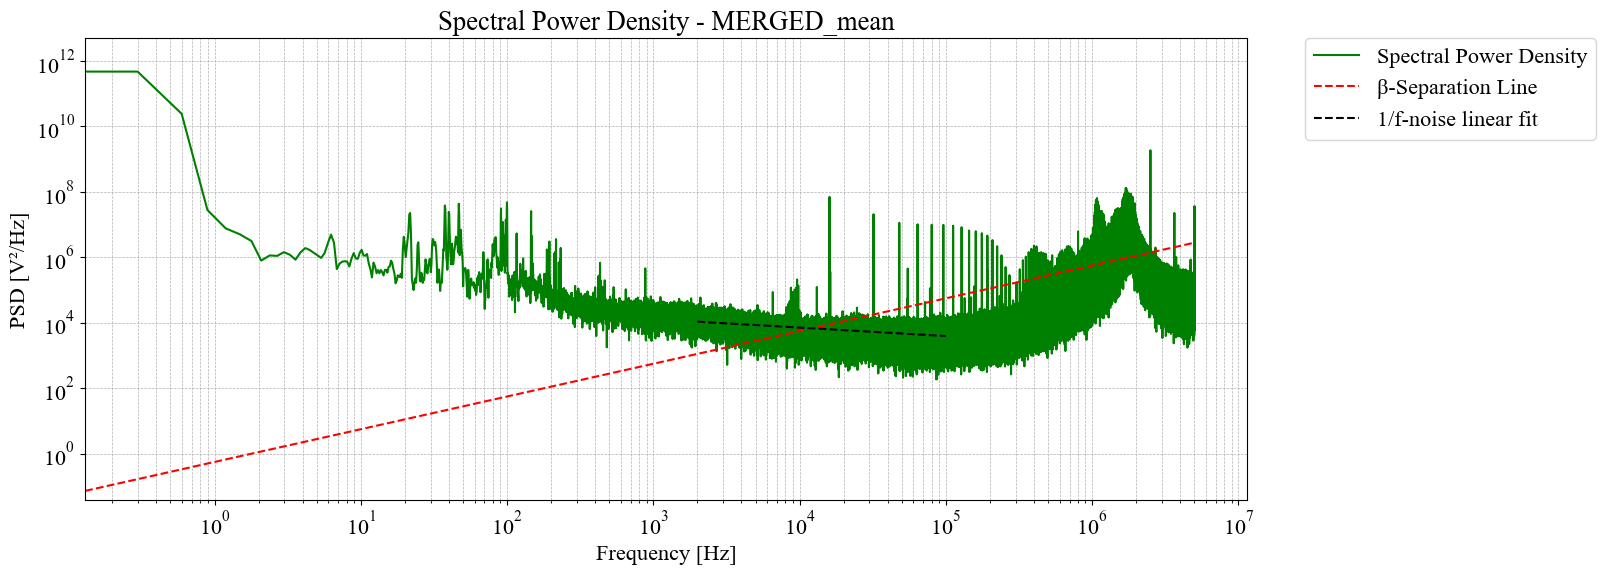

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set font properties for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Ensure f never reaches 0
    return A * f_safe**(-B)

def process_parquet_file(parquet_filename, freq_column="X", psd_column="Y"):
    try:
        # Read Parquet file
        data = pd.read_parquet(parquet_filename)
    except Exception as e:
        print(f"Error reading {parquet_filename}: {e}")
        return

    # Extract frequency and PSD columns
    if freq_column not in data.columns or psd_column not in data.columns:
        print(f"Columns '{freq_column}' and/or '{psd_column}' not found in {parquet_filename}.")
        return
    
    global freq_locked
    freq_locked = data[freq_column].values  # Frequency axis (X)
    global psds_locked
    psds_locked = data[psd_column].values   # Power spectral density (Y)

    print(f'Processing {parquet_filename}...')

    # Compute the β-separation line
    global beta_sep_full
    beta_sep_full = (8 * np.log(2) / (np.pi**2)) * freq_locked

    # Define fitting range for 1/f noise (select relevant frequency region)
    idx = np.where((freq_locked > 2e3) & (psds_locked < 4e7) & (freq_locked < 1e5))

    freq_idx = freq_locked[idx[0]]
    psds_idx = psds_locked[idx[0]]

    if len(freq_idx) == 0 or len(psds_idx) == 0:
        print("No valid data points for curve fitting.")
        return

    # Curve fitting with power law (1/f noise)
    try:
        popt_ps, _ = curve_fit(
            power_law, freq_idx, psds_idx, 
            p0=[1e6, 1],  # Initial values
            bounds=([1e-6, 0], [1e12, 5])  # Bounds for A and B
        )
    except RuntimeError:
        print("Curve fitting failed.")
        return

    # Compute fitted curve
    fit_curve = power_law(freq_idx, *popt_ps)

    # Compute intersection with β-separation line
    beta_sep = (8 * np.log(2) / (np.pi**2)) * freq_idx
    id_crossing = np.argwhere(np.diff(np.sign(fit_curve - beta_sep))).flatten()

    if len(id_crossing) > 0:
        global cfreq_locked
        cfreq_locked = freq_idx[id_crossing][0]
        print(f'Schnittpunkt der 1/f-Kurve mit der Beta-Linie: {cfreq_locked * 1e-3:.3f} kHz')
    else:
        print("No intersection found.")

    # Plot spectral power density
    plt.figure(figsize=(15, 6))
    plt.loglog(freq_locked, psds_locked, label='Spectral Power Density', color='green')
    plt.loglog(freq_locked, beta_sep_full, 'r--', label='β-Separation Line')
    plt.loglog(freq_idx, fit_curve, label=f'1/f-noise linear fit', color='black', linestyle='--')



    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V²/Hz]')
    plt.title(f'Spectral Power Density - {os.path.basename(parquet_filename)}')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()



input_folder_data = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_locked\\Parquet_locked_FF_PSD\\MERGED_mean'

# Example usage: Change the path to your folder containing Parquet files
process_parquet_file(input_folder_data, freq_column="Frequenz (Hz)", psd_column="PSD")



### Area and FHNW 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid  # Importing trapezoid from scipy


def integrate_psd_data(freq, psds, cfreq):
    """Berechnet die Fläche unter der PSD-Kurve von 10 Hz bis cfreq"""
    
    global f_min_locked
    f_min_locked = 1  # Untere Integrationsgrenze
    global f_max_locked
    f_max_locked = cfreq  # Obere Integrationsgrenze

    # Filter: Frequenzen und zugehörige PSD-Werte im Integrationsbereich auswählen
    mask = (freq >= f_min_locked) & (freq <= f_max_locked)
    freq_selected = freq[mask]
    psds_selected = psds[mask]

    if len(freq_selected) < 2:
        print("Nicht genügend Datenpunkte für die Integration.")
        return None

    # Integration der PSD-Daten mit der Simpson-Regel (präziser als Trapezregel)
    global A1_locked
    A1_locked = np.trapezoid(psds_selected, freq_selected)


    print(f"A1_locked (Fläche unter der PSD-Kurve von {f_min_locked} Hz bis {f_max_locked} Hz): {A1_locked:.3e}")
    return A1_locked

# Beispielaufruf mit den berechneten PSD-Werten und Frequenzen
# (freq und psds stammen aus deinem vorherigen Code!)
#cfreq = 25000  # Beispielwert für den Schnittpunkt in Hz
A1 = integrate_psd_data(freq_locked, psds_locked, cfreq_locked)
print("Area A1-locked is:", A1)


A1_locked (Fläche unter der PSD-Kurve von 1 Hz bis 12126.266955571347 Hz): 3.991e+08
Area A1-locked is: 399088449.5033838


### Calculate FWHM

In [4]:
global FWHM_locked
FWHM_locked = 1e-3 * np.sqrt(8* np.log(2) * A1_locked)

print("FWHM:", FWHM_locked, "kHz")

FWHM: 47.042706858114414 kHz


## Unlocked

### Converting into frequency and PSD - doing FF and using convertion factor

In [3]:
import os
import numpy as np
import pandas as pd

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Sicherstellen, dass f nie 0 ist
    return A * f_safe**(-B)

def process_parquet_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for file in os.listdir(input_folder):
        if file.endswith(".parquet"):
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)
            
            try:
                data = pd.read_parquet(input_path)
            except Exception as e:
                print(f"Fehler beim Einlesen von {file}: {e}")
                continue
            
            time = data.iloc[:, 0].values  # Zeit
            sig = data.iloc[:, 1].values  # Signal
            
            # Parameter für Spektrale Leistungsdichte
            zff = 1
            coeff_VHz = 0.576e-6
            print(f'Conversion V/Hz : {coeff_VHz * 1e6:.4f} V/MHz')
            
            # FFT-Länge berechnen
            fft_length = int(2**(np.floor(np.log2(len(sig))) + zff))
            
            spc = np.abs(np.fft.rfft(np.blackman(len(time)) * (sig / -coeff_VHz), fft_length)) / len(time)
            freq = np.fft.rfftfreq(fft_length, np.mean(np.diff(time)))
            
            psds = 2 * spc**2 / (
                np.sum(np.blackman(len(time))**2) 
                / (len(sig)**2 * np.mean(np.diff(time)))
            )
            
            # Daten in DataFrame speichern und als Parquet exportieren
            result_df = pd.DataFrame({'Frequenz (Hz)': freq, 'PSD': psds})
            result_df.to_parquet(output_path, index=False)
            print(f"Ergebnis gespeichert: {output_path}")

input_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_unlocked'
output_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_unlocked\\Parquet_unlocked_FF_PDS'

process_parquet_files(input_folder, output_folder)

Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_unlocked\Parquet_unlocked_FF_PDS\fixed_f_0V_withoutCAVITY_01.parquet
Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_unlocked\Parquet_unlocked_FF_PDS\fixed_f_0V_withoutCAVITY_02.parquet
Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_unlocked\Parquet_unlocked_FF_PDS\fixed_f_0V_withoutCAVITY_03.parquet


### Statistics

In [10]:
import os
import pandas as pd
import numpy as np

def merge_parquet_files(input_folder, output_folder, freq_column="Frequency", output_filename="merged.parquet"):
    all_data = []
    
    # Read all Parquet files in the input folder
    for file in sorted(os.listdir(input_folder)):  # Ensure order consistency
        if file.endswith(".parquet"):
            file_path = os.path.join(input_folder, file)
            df = pd.read_parquet(file_path)
            all_data.append(df)
    
    if not all_data:
        print("No Parquet files found in the specified folder.")
        return
    
    # Stack all data into a 3D NumPy array (rows x columns x files)
    stacked_data = np.stack([df.values for df in all_data], axis=2)

    # Compute mean across files (axis=2)
    mean_values = np.mean(stacked_data, axis=2)
    
    # Compute std deviation across files only for the Frequency column
    if freq_column in all_data[0].columns:
        freq_idx = all_data[0].columns.get_loc(freq_column)  # Get index of frequency column
        freq_std = np.std(stacked_data[:, freq_idx, :], axis=1)  # Standard deviation for each row
        
        # Calculate the mean of the frequency standard deviation column
        mean_freq_std = np.mean(freq_std)
        print(f"Mean of the Frequency Standard Deviation column: {mean_freq_std}")
    else:
        print(f"Column '{freq_column}' not found. Skipping standard deviation calculation.")
        freq_std = np.zeros(mean_values.shape[0])  # Placeholder if column is missing
    
    # Create DataFrame for output
    output_df = pd.DataFrame(mean_values, columns=all_data[0].columns)
    output_df[f"{freq_column}_std"] = freq_std  # Add frequency standard deviation column
    
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Save to new Parquet file
    output_path = os.path.join(output_folder, output_filename)
    output_df.to_parquet(output_path)
    
    print(f"Merged file saved at: {output_path}")


path_to_input_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_unlocked\\Parquet_unlocked_FF_PDS'
path_to_output_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_unlocked\\Parquet_unlocked_FF_PDS\\MERGED_mean'

merge_parquet_files(path_to_input_folder, path_to_output_folder, freq_column="Frequenz (Hz)")

Mean of the Frequency Standard Deviation column: 2.9528454064521313e-10
Merged file saved at: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_unlocked\Parquet_unlocked_FF_PDS\MERGED_mean\merged.parquet


### Plot all Data - unlocked


Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_unlocked\Parquet_unlocked_FF_PDS\fixed_f_0V_withoutCAVITY_01.parquet...
Schnittpunkt der 1/f-Kurve mit der Beta-Linie: 402.583 kHz


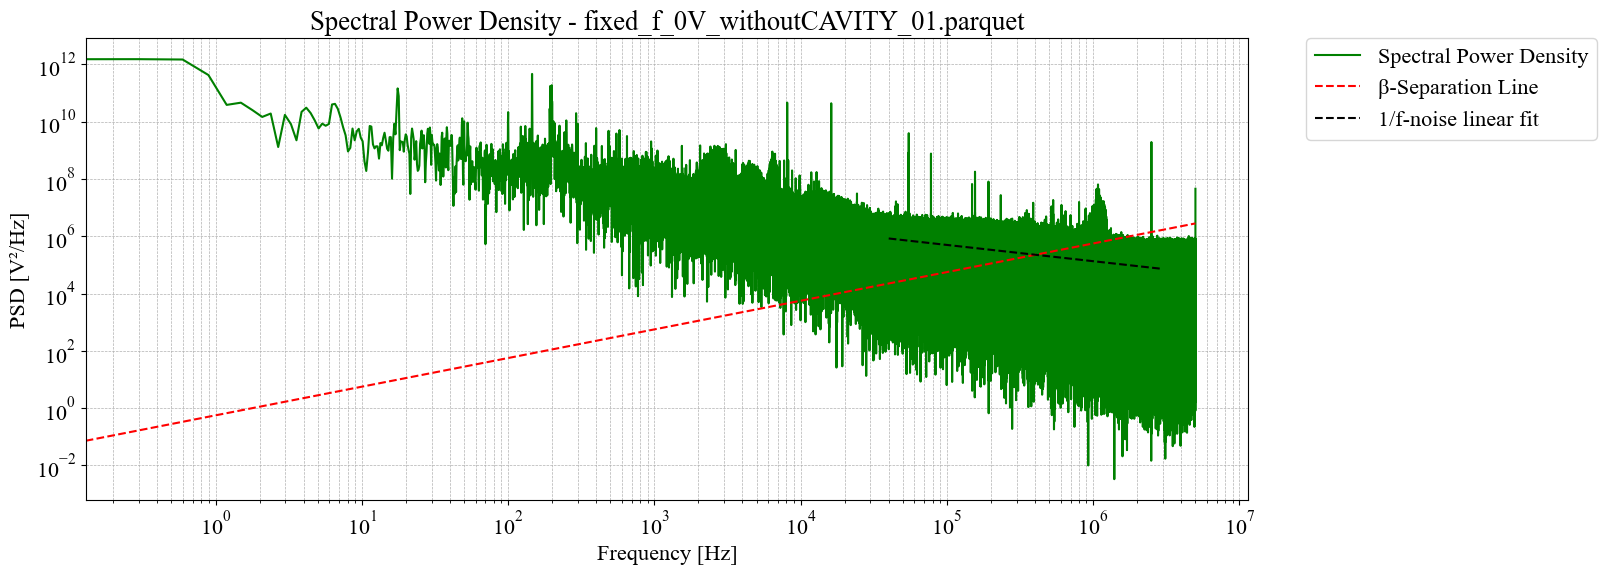

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_unlocked\Parquet_unlocked_FF_PDS\fixed_f_0V_withoutCAVITY_02.parquet...


KeyboardInterrupt: 

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set font properties for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Ensure f never reaches 0
    return A * f_safe**(-B)

def process_parquet_file(parquet_filename, freq_column="X", psd_column="Y"):
    try:
        # Read Parquet file
        data = pd.read_parquet(parquet_filename)
    except Exception as e:
        print(f"Error reading {parquet_filename}: {e}")
        return

    # Extract frequency and PSD columns
    if freq_column not in data.columns or psd_column not in data.columns:
        print(f"Columns '{freq_column}' and/or '{psd_column}' not found in {parquet_filename}.")
        return
    
    freq = data[freq_column].values  # Frequency axis (X)
    psds = data[psd_column].values   # Power spectral density (Y)

    print(f'Processing {parquet_filename}...')

    # Compute the β-separation line
    beta_sep_full = (8 * np.log(2) / (np.pi**2)) * freq

    # Define fitting range for 1/f noise (select relevant frequency region)
    idx = np.where((freq > 4e4) & (psds < 4e7) & (freq < 3e6))

    freq_idx = freq[idx[0]]
    psds_idx = psds[idx[0]]

    if len(freq_idx) == 0 or len(psds_idx) == 0:
        print("No valid data points for curve fitting.")
        return

    # Curve fitting with power law (1/f noise)
    try:
        popt_ps, _ = curve_fit(
            power_law, freq_idx, psds_idx, 
            p0=[1e6, 1],  # Initial values
            bounds=([1e-6, 0], [1e12, 5])  # Bounds for A and B
        )
    except RuntimeError:
        print("Curve fitting failed.")
        return

    # Compute fitted curve
    fit_curve = power_law(freq_idx, *popt_ps)

    # Compute intersection with β-separation line
    beta_sep = (8 * np.log(2) / (np.pi**2)) * freq_idx
    id_crossing = np.argwhere(np.diff(np.sign(fit_curve - beta_sep))).flatten()

    if len(id_crossing) > 0:
        global cfreq_unlocked
        cfreq_unlocked = freq_idx[id_crossing][0]
        print(f'Schnittpunkt der 1/f-Kurve mit der Beta-Linie: {cfreq_unlocked * 1e-3:.3f} kHz')
    else:
        print("No intersection found.")

    # Plot spectral power density
    plt.figure(figsize=(15, 6))
    plt.loglog(freq, psds, label='Spectral Power Density', color='green')
    plt.loglog(freq, beta_sep_full, 'r--', label='β-Separation Line')
    plt.loglog(freq_idx, fit_curve, label=f'1/f-noise linear fit', color='black', linestyle='--')

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V²/Hz]')
    plt.title(f'Spectral Power Density - {os.path.basename(parquet_filename)}')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def process_parquet_files(folder_path, freq_column="X", psd_column="Y"):
    """Iterates over all Parquet files in the folder and processes them."""
    for file in sorted(os.listdir(folder_path)):  # Sort for consistency
        if file.endswith(".parquet"):
            file_path = os.path.join(folder_path, file)
            process_parquet_file(file_path, freq_column, psd_column)


input_folder_data = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_unlocked\\Parquet_unlocked_FF_PDS'

# Example usage: Change the path to your folder containing Parquet files
process_parquet_files(input_folder_data, freq_column="Frequenz (Hz)", psd_column="PSD")


### Plot the Mean - unlocked

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_unlocked\Parquet_unlocked_FF_PDS\MERGED_mean...
Schnittpunkt der 1/f-Kurve mit der Beta-Linie: 406.787 kHz


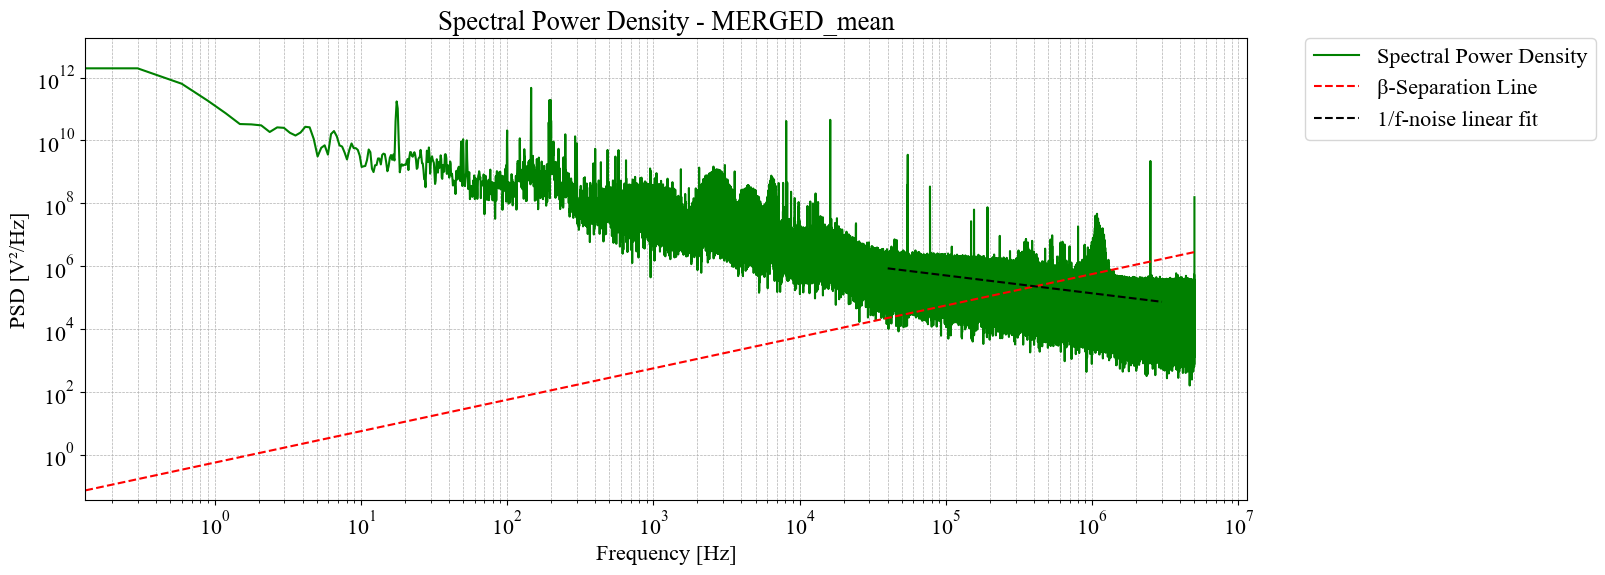

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set font properties for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Ensure f never reaches 0
    return A * f_safe**(-B)

def process_parquet_file(parquet_filename, freq_column="X", psd_column="Y"):
    try:
        # Read Parquet file
        data = pd.read_parquet(parquet_filename)
    except Exception as e:
        print(f"Error reading {parquet_filename}: {e}")
        return

    # Extract frequency and PSD columns
    if freq_column not in data.columns or psd_column not in data.columns:
        print(f"Columns '{freq_column}' and/or '{psd_column}' not found in {parquet_filename}.")
        return
    
    global freq_unlocked
    freq_unlocked = data[freq_column].values  # Frequency axis (X)
    global psds_unlocked
    psds_unlocked = data[psd_column].values   # Power spectral density (Y)

    print(f'Processing {parquet_filename}...')

    # Compute the β-separation line
    beta_sep_full = (8 * np.log(2) / (np.pi**2)) * freq_unlocked

    # Define fitting range for 1/f noise (select relevant frequency region)
    idx = np.where((freq_unlocked > 4e4) & (psds_unlocked < 4e7) & (freq_unlocked < 3e6))

    freq_idx = freq_unlocked[idx[0]]
    psds_idx = psds_unlocked[idx[0]]

    if len(freq_idx) == 0 or len(psds_idx) == 0:
        print("No valid data points for curve fitting.")
        return

    # Curve fitting with power law (1/f noise)
    try:
        popt_ps, _ = curve_fit(
            power_law, freq_idx, psds_idx, 
            p0=[1e6, 1],  # Initial values
            bounds=([1e-6, 0], [1e12, 5])  # Bounds for A and B
        )
    except RuntimeError:
        print("Curve fitting failed.")
        return

    # Compute fitted curve
    fit_curve = power_law(freq_idx, *popt_ps)

    # Compute intersection with β-separation line
    beta_sep = (8 * np.log(2) / (np.pi**2)) * freq_idx
    id_crossing = np.argwhere(np.diff(np.sign(fit_curve - beta_sep))).flatten()

    if len(id_crossing) > 0:
        global cfreq_unlocked
        cfreq_unlocked = freq_idx[id_crossing][0]
        print(f'Schnittpunkt der 1/f-Kurve mit der Beta-Linie: {cfreq_unlocked * 1e-3:.3f} kHz')
    else:
        print("No intersection found.")

    # Plot spectral power density
    plt.figure(figsize=(15, 6))
    plt.loglog(freq_unlocked, psds_unlocked, label='Spectral Power Density', color='green')
    plt.loglog(freq_unlocked, beta_sep_full, 'r--', label='β-Separation Line')
    plt.loglog(freq_idx, fit_curve, label=f'1/f-noise linear fit', color='black', linestyle='--')



    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V²/Hz]')
    plt.title(f'Spectral Power Density - {os.path.basename(parquet_filename)}')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()



input_folder_data = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_unlocked\\Parquet_unlocked_FF_PDS\\MERGED_mean'

# Example usage: Change the path to your folder containing Parquet files
process_parquet_file(input_folder_data, freq_column="Frequenz (Hz)", psd_column="PSD")



### Area and FWHM

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid  # Importing trapezoid from scipy


def integrate_psd_data(freq, psds, cfreq):
    """Berechnet die Fläche unter der PSD-Kurve von 10 Hz bis cfreq"""
    
    global f_min_unlocked
    f_min_unlocked = 1  # Untere Integrationsgrenze
    global f_max_unlocked
    f_max_unlocked = cfreq  # Obere Integrationsgrenze

    # Filter: Frequenzen und zugehörige PSD-Werte im Integrationsbereich auswählen
    mask = (freq >= f_min_unlocked) & (freq <= f_max_unlocked)
    freq_selected = freq[mask]
    psds_selected = psds[mask]

    if len(freq_selected) < 2:
        print("Nicht genügend Datenpunkte für die Integration.")
        return None

    # Integration der PSD-Daten mit der Simpson-Regel (präziser als Trapezregel)
    global A1_unlocked
    A1_unlocked = np.trapezoid(psds_selected, freq_selected)


    print(f"A1_unlocked (Fläche unter der PSD-Kurve von {f_min_unlocked} Hz bis {f_max_unlocked} Hz): {A1_unlocked:.3e}")
    return A1_unlocked

# Beispielaufruf mit den berechneten PSD-Werten und Frequenzen
# (freq und psds stammen aus deinem vorherigen Code!)
#cfreq = 25000  # Beispielwert für den Schnittpunkt in Hz
A1 = integrate_psd_data(freq_unlocked, psds_unlocked, cfreq_unlocked)
print("Area A1-unlocked is:", A1)


A1_unlocked (Fläche unter der PSD-Kurve von 1 Hz bis 406786.5013821954 Hz): 1.591e+12
Area A1-unlocked is: 1590809180342.5547


In [7]:

global FWHM_unlocked
FWHM_unlocked = 1e-6 * np.sqrt(8* np.log(2) * A1_unlocked)

print("FWHM:", FWHM_unlocked, "MHz")

FWHM: 2.9700705690785454 MHz


## Darknois

### Converting into frequency and PSD - doing FF and using convertion factor

In [18]:
import os
import numpy as np
import pandas as pd

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Sicherstellen, dass f nie 0 ist
    return A * f_safe**(-B)

def process_parquet_files(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for file in os.listdir(input_folder):
        if file.endswith(".parquet"):
            input_path = os.path.join(input_folder, file)
            output_path = os.path.join(output_folder, file)
            
            try:
                data = pd.read_parquet(input_path)
            except Exception as e:
                print(f"Fehler beim Einlesen von {file}: {e}")
                continue
            
            time = data.iloc[:, 0].values  # Zeit
            sig = data.iloc[:, 1].values  # Signal
            
            # Parameter für Spektrale Leistungsdichte
            zff = 1
            coeff_VHz = 0.576e-6
            print(f'Conversion V/Hz : {coeff_VHz * 1e6:.4f} V/MHz')
            
            # FFT-Länge berechnen
            fft_length = int(2**(np.floor(np.log2(len(sig))) + zff))
            
            spc = np.abs(np.fft.rfft(np.blackman(len(time)) * (sig / -coeff_VHz), fft_length)) / len(time)
            freq = np.fft.rfftfreq(fft_length, np.mean(np.diff(time)))
            
            psds = 2 * spc**2 / (
                np.sum(np.blackman(len(time))**2) 
                / (len(sig)**2 * np.mean(np.diff(time)))
            )
            
            # Daten in DataFrame speichern und als Parquet exportieren
            result_df = pd.DataFrame({'Frequenz (Hz)': freq, 'PSD': psds})
            result_df.to_parquet(output_path, index=False)
            print(f"Ergebnis gespeichert: {output_path}")

input_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_Darknois'
output_folder = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_Darknois\\Parquet_Darknois_FF_PSD'

process_parquet_files(input_folder, output_folder)

Conversion V/Hz : 0.5760 V/MHz
Ergebnis gespeichert: C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_Darknois\Parquet_Darknois_FF_PSD\OFD_noise_floor.parquet


### Plot the Noise

Processing C:\Users\samse\Desktop\Blockkurs\07-UltracoldIons\Repository\Datenanalysis_PSD\ParquetData\Parquet_Darknois\Parquet_Darknois_FF_PSD...
Schnittpunkt der 1/f-Kurve mit der Beta-Linie: 0.510 kHz


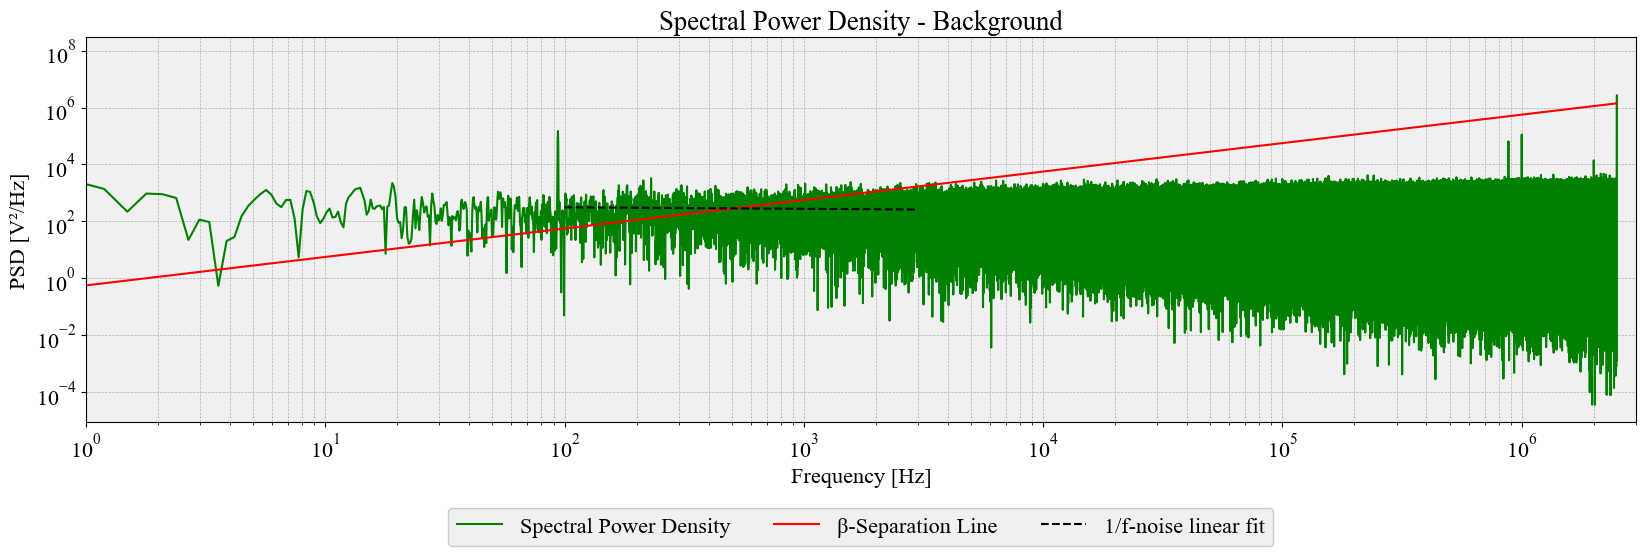

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set font properties for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 16

def power_law(f, A, B):
    """1/f-Funktion mit Schutz vor Null-Werten"""
    f_safe = np.maximum(f, 1e-6)  # Ensure f never reaches 0
    return A * f_safe**(-B)

def process_parquet_file(parquet_filename, freq_column="X", psd_column="Y"):
    try:
        # Read Parquet file
        data = pd.read_parquet(parquet_filename)
    except Exception as e:
        print(f"Error reading {parquet_filename}: {e}")
        return

    # Extract frequency and PSD columns
    if freq_column not in data.columns or psd_column not in data.columns:
        print(f"Columns '{freq_column}' and/or '{psd_column}' not found in {parquet_filename}.")
        return
    
    global freq_noise
    freq_01 = data[freq_column].values  # Frequency axis (X)

    global psds_noise
    psds_noise = data[psd_column].values   # Power spectral density (Y)

    freq_noise = freq_01[:len(psds_noise)]  # Adjust to match PSD length


    print(f'Processing {parquet_filename}...')

    # Compute the β-separation line
    beta_sep_full = (8 * np.log(2) / (np.pi**2)) * freq_noise

    # Define fitting range for 1/f noise (select relevant frequency region)
    idx = np.where((freq_noise > 1e2) & (psds_noise < 4e7) & (freq_noise < 3e3))

    freq_idx = freq_noise[idx[0]]
    psds_idx = psds_noise[idx[0]]

    if len(freq_idx) == 0 or len(psds_idx) == 0:
        print("No valid data points for curve fitting.")
        return

    # Curve fitting with power law (1/f noise)
    try:
        popt_ps, _ = curve_fit(
            power_law, freq_idx, psds_idx, 
            p0=[1e6, 1],  # Initial values
            bounds=([1e-6, 0], [1e12, 5])  # Bounds for A and B
        )
    except RuntimeError:
        print("Curve fitting failed.")
        return

    # Compute fitted curve
    fit_curve = power_law(freq_idx, *popt_ps)

    # Compute intersection with β-separation line
    beta_sep = (8 * np.log(2) / (np.pi**2)) * freq_idx
    id_crossing = np.argwhere(np.diff(np.sign(fit_curve - beta_sep))).flatten()

    if len(id_crossing) > 0:
        global cfreq_noise
        cfreq_noise = freq_idx[id_crossing][0]
        print(f'Schnittpunkt der 1/f-Kurve mit der Beta-Linie: {cfreq_noise * 1e-3:.3f} kHz')
    else:
        print("No intersection found.")

    # Plot spectral power density
    plt.figure(figsize=(20, 5))
    plt.loglog(freq_noise, psds_noise, label='Spectral Power Density', color='green')
    plt.loglog(freq_noise, beta_sep_full, 'r', label='β-Separation Line')
    plt.loglog(freq_idx, fit_curve, label=f'1/f-noise linear fit', color='black', linestyle='--')

    plt.gca().set_facecolor('#F0F0F0')  # Hintergrund des Plots auf Grau setzen

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V²/Hz]')
    plt.title(f'Spectral Power Density - Background')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3, facecolor='#F0F0F0', framealpha=1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlim(1e0, 3e6)
    plt.show()



input_folder_data = 'C:\\Users\\samse\\Desktop\\Blockkurs\\07-UltracoldIons\\Repository\\Datenanalysis_PSD\\ParquetData\\Parquet_Darknois\\Parquet_Darknois_FF_PSD'

# Example usage: Change the path to your folder containing Parquet files
process_parquet_file(input_folder_data, freq_column="Frequenz (Hz)", psd_column="PSD")



### Area and Noise

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid  # Importing trapezoid from scipy


def integrate_psd_data(freq, psds, cfreq):
    """Berechnet die Fläche unter der PSD-Kurve von 10 Hz bis cfreq"""
    
    global f_min_noise
    f_min_noise = 1  # Untere Integrationsgrenze
    global f_max_unlocked
    f_max_noise = cfreq  # Obere Integrationsgrenze

    # Filter: Frequenzen und zugehörige PSD-Werte im Integrationsbereich auswählen
    mask = (freq >= f_min_noise) & (freq <= f_max_noise)
    freq_selected = freq[mask]
    psds_selected = psds[mask]

    if len(freq_selected) < 2:
        print("Nicht genügend Datenpunkte für die Integration.")
        return None

    # Integration der PSD-Daten mit der Simpson-Regel (präziser als Trapezregel)
    global A1_noise
    A1_noise = np.trapezoid(psds_selected, freq_selected)


    print(f"A1_unlocked (Fläche unter der PSD-Kurve von {f_min_noise} Hz bis {f_max_noise} Hz): {A1_unlocked:.3e}")
    return A1_noise

# Beispielaufruf mit den berechneten PSD-Werten und Frequenzen
# (freq und psds stammen aus deinem vorherigen Code!)
#cfreq = 25000  # Beispielwert für den Schnittpunkt in Hz
A1 = integrate_psd_data(freq_noise, psds_noise, cfreq_noise)
print("Area A1-noise is:", A1)


A1_unlocked (Fläche unter der PSD-Kurve von 1 Hz bis 509.9177360534583 Hz): 1.591e+12
Area A1-noise is: 231280.60630705094


In [10]:

global FWHM_noise
FWHM_noise = 1e-3 * np.sqrt(8* np.log(2) * A1_noise)

print("FWHM:", FWHM_noise, "kHz")

FWHM: 1.1324716338343388 kHz


# Summary

In [ ]:
print("DATA-LOCKED, Setpoint:", 1e-3 * cfreq_locked, "kHz, FWHM", FWHM_locked, "kHz")
print("DATA-UNLOCKED, Setpoint:", 1e-3 * cfreq_unlocked, "kHz, FWHM", FWHM_unlocked, "kHz")
print("DATA-NOISE, Setpoint:", cfreq_noise, "Hz, FWHM", FWHM_noise, "kHz")

#Für integral von 1Hz bis schnittpunkt!!

DATA-LOCKED, Setpoint: 12.126266955571348 kHz, FWHM 47.042706858114414 kHz
DATA-UNLOCKED, Setpoint: 406.7865013821954 kHz, FWHM 2.9700705690785454 kHz
DATA-NOISE, Setpoint: 509.9177360534583 Hz, FWHM 1.1324716338343388 kHz


# Plot all in one!

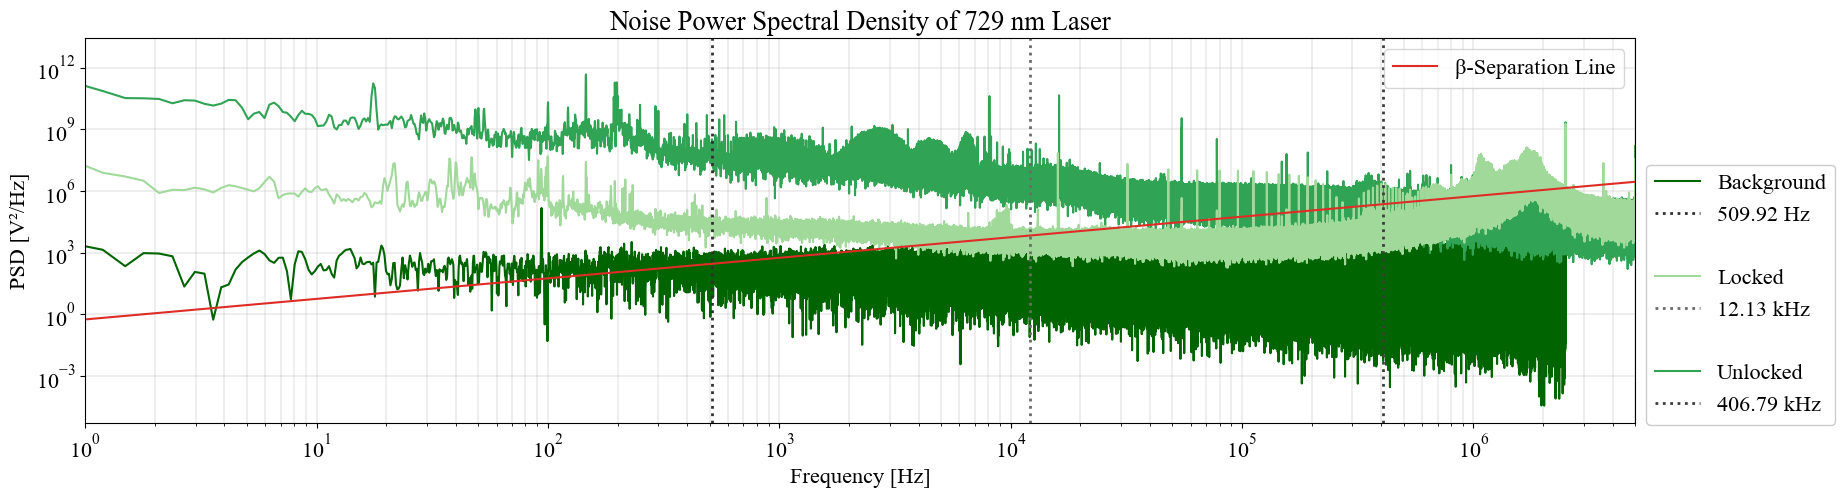

In [64]:
# Plot spectral power density
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.figure(figsize=(20, 5))

# Hauptkurven plotten
l1, = plt.loglog(freq_noise, psds_noise, label='Background', color='#006400')
l2, = plt.loglog(freq_unlocked, psds_unlocked, label='Unlocked', color='#31a354')
l3, = plt.loglog(freq_locked, psds_locked, label='Locked', color='#a1d99b')
l4, = plt.loglog(freq_locked, beta_sep_full, color='#de2d26', label='β-Separation Line')



# Vertikale Linien für Schnittpunkte
m1 = plt.axvline(x=cfreq_locked, color='#6B6B6B', linestyle=':', linewidth=2, label=rf'{1e-3 * cfreq_locked:.2f} kHz')
m2 = plt.axvline(x=cfreq_unlocked, color='#3D3D3D', linestyle=':', linewidth=2, label=rf'{1e-3 * cfreq_unlocked:.2f} kHz')
m3 = plt.axvline(x=cfreq_noise, color='#303030', linestyle=':', linewidth=2, label=rf'{cfreq_noise:.2f} Hz')

# Zweite Legende für die Schnittpunkte
m_legend = plt.legend(handles=[l4])
#facecolor='#F0F0F0, title="Intersection 1/f noise & β-Separation Line",'

empty_handle = mlines.Line2D([], [], color=(0,0,0,0))  # Unsichtbare Linie
# Erste Legende für die Spektren
l_legend = plt.legend(handles=[l1, m3, empty_handle,  l3, m1, empty_handle, l2, m2], loc='upper left', bbox_to_anchor=(1.0, 0.7), framealpha=1, ncol=1)
#facecolor='#F0F0F0, title="Spectral Power Density Data",'


# Erste Legende erneut zum Plot hinzufügen
plt.gca().add_artist(m_legend)

# Achsenbeschriftung & Titel
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.title('Noise Power Spectral Density of 729 nm Laser')

#plt.gca().set_facecolor('#F0F0F0')  # Hintergrund des Plots auf Grau setzen


# Grid & Limits
plt.grid(True, which='both', linestyle='-', linewidth=0.3)
plt.xlim(1e0, 5e6)

plt.show()




# Plot Laser Linewidth

### Calculate Area and FWHM for different times:

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid  # Importing trapezoid from scipy

#4000 Hz für 250 mus

f_min_locked = [1, 10, 100, 1000,4000, 10000]  # Untere Integrationsgrenze
f_min_unlocked = [1, 10, 100, 1000, 10000, 100000]
f_min_noise = [1, 10, 100]

FWHM_locked_list = []
FWHM_unlocked_list = []
FWHM_noise_list = []

def integrate_psd_data(freq, psds, cfreq, f_min, list):
    """Berechnet die Fläche unter der PSD-Kurve von 10 Hz bis cfreq"""
    #10 herz entspricht 100ms!!!
    
    f_max = cfreq  # Obere Integrationsgrenze

    # Filter: Frequenzen und zugehörige PSD-Werte im Integrationsbereich auswählen
    for Hz in f_min:
        mask = (freq >= Hz) & (freq <= f_max)
        freq_selected = freq[mask]
        psds_selected = psds[mask]

        if len(freq_selected) < 2:
            print("Nicht genügend Datenpunkte für die Integration.")
            return None

    # Integration der PSD-Daten mit der Simpson-Regel (präziser als Trapezregel)
        A1_frequenz = np.trapezoid(psds_selected, freq_selected)

        FWHM  = 1e-3 * np.sqrt(8* np.log(2) * A1_frequenz)

        
        list.append(round(float(FWHM),5))

        print(f"A1 von {Hz} Hz bis {round(f_max, 2)} Hz: {A1_frequenz:.2e} and FWHM is {round(FWHM, 2)} kHz")
    print(list)
        
        
print("Locked Data")
integrate_psd_data(freq_locked, psds_locked, cfreq_locked, f_min_locked, FWHM_locked_list)
print("Unlocked Data")
integrate_psd_data(freq_unlocked, psds_unlocked, cfreq_unlocked, f_min_unlocked, FWHM_unlocked_list)
print("Noise Data")
integrate_psd_data(freq_noise, psds_noise, cfreq_noise, f_min_noise, FWHM_noise_list)




Locked Data
A1 von 1 Hz bis 12126.27 Hz: 3.99e+08 and FWHM is 47.04 kHz
A1 von 10 Hz bis 12126.27 Hz: 3.84e+08 and FWHM is 46.17 kHz
A1 von 100 Hz bis 12126.27 Hz: 1.67e+08 and FWHM is 30.41 kHz
A1 von 1000 Hz bis 12126.27 Hz: 9.12e+07 and FWHM is 22.49 kHz
A1 von 4000 Hz bis 12126.27 Hz: 5.16e+07 and FWHM is 16.92 kHz
A1 von 10000 Hz bis 12126.27 Hz: 1.06e+07 and FWHM is 7.66 kHz
[47.04271, 46.16999, 30.40955, 22.48714, 16.91565, 7.6581]
Unlocked Data
A1 von 1 Hz bis 406786.5 Hz: 1.59e+12 and FWHM is 2970.07 kHz
A1 von 10 Hz bis 406786.5 Hz: 1.46e+12 and FWHM is 2845.33 kHz
A1 von 100 Hz bis 406786.5 Hz: 1.25e+12 and FWHM is 2628.32 kHz
A1 von 1000 Hz bis 406786.5 Hz: 4.32e+11 and FWHM is 1547.53 kHz
A1 von 10000 Hz bis 406786.5 Hz: 2.47e+11 and FWHM is 1171.29 kHz
A1 von 100000 Hz bis 406786.5 Hz: 1.08e+11 and FWHM is 772.15 kHz
[2970.07057, 2845.32685, 2628.32376, 1547.53109, 1171.2931, 772.15474]
Noise Data
A1 von 1 Hz bis 509.92 Hz: 2.31e+05 and FWHM is 1.13 kHz
A1 von 10 Hz bis 5

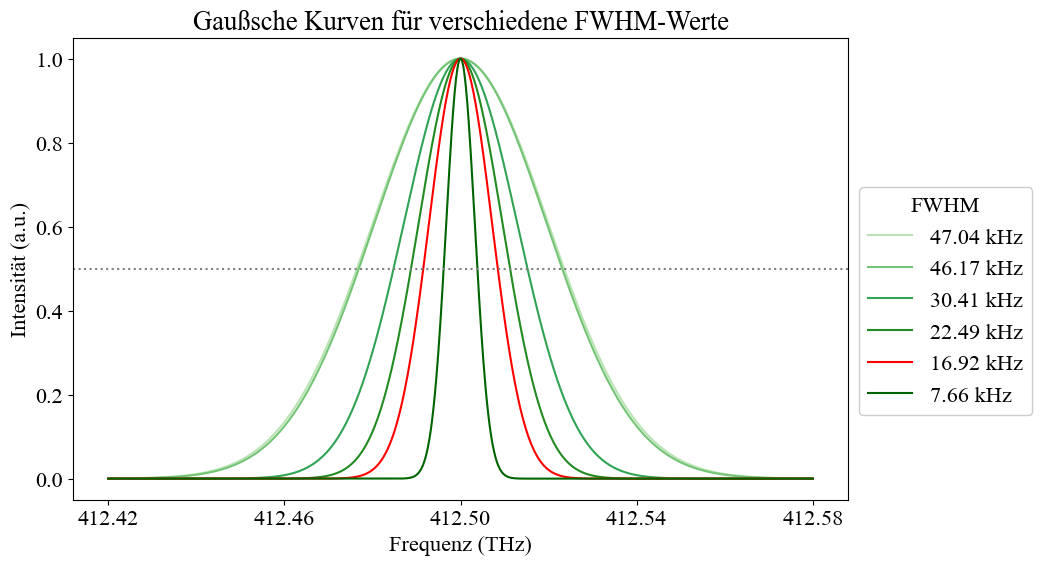

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def gaussian(x, mu, sigma):
    """Berechne die Gaußsche Funktion."""
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def fwhm_to_sigma(fwhm):
    """Konvertiere FWHM in die Standardabweichung (Sigma)."""
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def plot_gaussian(fwhm_list, mu_thz=412.5, x_range=(412.42, 412.58), num_points=1000):
    # Umrechnung von THz in kHz (1 THz = 1.000.000 kHz)
    mu_khz = mu_thz * 1_000_000
    x_khz = np.linspace(x_range[0]*1_000_000, x_range[1]*1_000_000, num_points)

    plt.figure(figsize=(10,6))

    # Definiere 6 Hex-Farben für die einzelnen Plots:

    colors = ['#bae4b3', '#74c476', '#31a354', '#228B22', 'r', '#006400']

    for i, fwhm in enumerate(fwhm_list):
        sigma = fwhm_to_sigma(fwhm * 1_000)  # FWHM von THz in kHz umrechnen
        y = gaussian(x_khz, mu_khz, sigma)
        
        # Plotten in THz (x_khz/1e6), damit die x-Achse in THz erscheint
        plt.plot(x_khz / 1e6, y, label=f'{fwhm:.2f} kHz', color= colors[i % len(colors)])

    # Linie bei halber Maximalhöhe
    plt.axhline(0.5, color='grey', linestyle=':')

    # Achsenbeschriftungen und Titel
    plt.xlabel('Frequenz (THz)')
    plt.ylabel('Intensität (a.u.)')
    plt.title('Gaußsche Kurven für verschiedene FWHM-Werte')
    plt.legend(title= 'FWHM', loc='upper left', bbox_to_anchor=(1.0, 0.7), framealpha=1, ncol=1)
    #plt.grid(True)

    # Beispiel: Wenige, selbstdefinierte Ticks in THz
    xticks = [412.42, 412.46, 412.50, 412.54, 412.58]
    plt.xticks(xticks)

    # Format der Ticks (z.B. 412.50). Wenn Du Kommas willst, kannst Du sie hier ersetzen.
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # Für Komma statt Punkt ggf.:
    # labels = [str(tick).replace('.', ',') for tick in xticks]
    # plt.xticks(xticks, labels)

    plt.show()


plot_gaussian(FWHM_locked_list)

